In [1]:
from evaluate_sdfdqn import *

/home/dof6/anaconda3/envs/grasp36/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# experiment configuration #
num_blocks = 3
max_blocks = 6
threshold = 2.5
max_steps = 20
gpu = 0
num_trials = 10
model = 'rulebased'
adj_ver = 0
selfloop = False
graph_normalize = False
resize = True
separate = False
bias = False
clip_sdf = False
round_sdf = False
depth = False
tracker = False
convex_hull = False
segmentation = False

In [3]:
# SDF module & Environment #
sdf_module = SDFModule(rgb_feature=True, resnet_feature=True, convex_hull=convex_hull, 
            binary_hole=True, using_depth=depth, tracker=False, resize=resize)
ur5robot = UR5Robot()
env = RealSDFEnv(ur5robot, sdf_module, num_blocks=num_blocks)

/home/dof6/Desktop/hogun_ur5/realrobot/../UnseenObjectClustering/fcn/config.py:439: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [4]:
# 1. Reset Robot Arm & Set Background Image#
background_img, _ = env.reset()
sdf_module.set_background(background_img[1])
#env.ur5.realsense = RealSenseSensor("141322252613")
#env.ur5.realsense.frames(spatial=True, hole_filling=True, temporal=True)

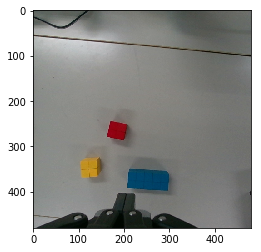

In [5]:
# 2. Set Goal Scene #
env.set_goals()
plt.imshow(env.goals[0])
plt.show()

In [63]:
# 3. Init Scene #
(state_img, goal_img) = env.reset()

sdf_st, sdf_raw, feature_st = sdf_module.get_sdf_features_with_ucn(state_img[0]/255., None, env.num_blocks, clip=clip_sdf)
sdf_g_b, _, feature_g = sdf_module.get_sdf_features_with_ucn(goal_img[0]/255., None, env.num_blocks, clip=clip_sdf)
sdf_g = sdf_module.make_round_sdf(sdf_g_b) if round_sdf else sdf_g_b

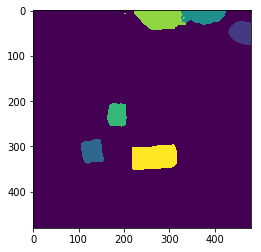

In [64]:
plt.imshow(sdf_module.detect_objects(state_img[0]/255., None, 'HWC'))

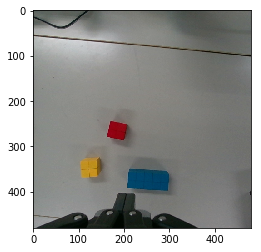

In [65]:
plt.imshow(goal_img[0])

In [45]:
sdf_g

array([], dtype=float64)

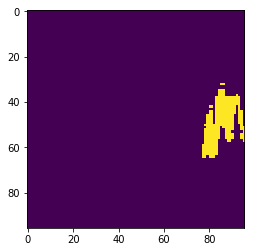

In [31]:
plt.imshow(sdf_g[8]>0)

In [43]:
# Visualize Goal Scene #
sdf_res = 96
cm = pylab.get_cmap('gist_rainbow')

vis_g = norm_npy(0*sdf_g_raw + 2*(sdf_g_raw>0).astype(float))
goal_sdfs = np.zeros([sdf_res, sdf_res, 3])
for _s in range(len(vis_g)):
    goal_sdfs += np.expand_dims(vis_g[_s], 2) * np.array(cm(_s/5)[:3])
plt.imshow(norm_npy(goal_sdfs))

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
# 4. Find Matching #
matching = sdf_module.object_matching(feature_st, feature_g)
sdf_st_align = sdf_module.align_sdf(matching, sdf_st, sdf_g)
sdf_raw = sdf_module.align_sdf(matching, sdf_raw, np.zeros([env.num_blocks, *sdf_raw.shape[1:]]))

In [ ]:
# Visualize Current Scene #
vis_c = norm_npy(0*sdf_st_align + 2*(sdf_st_align>0).astype(float))
current_sdfs = np.zeros([sdf_res, sdf_res, 3])
for _s in range(len(vis_c)):
    current_sdfs += np.expand_dims(vis_c[_s], 2) * np.array(cm(_s/5)[:3])
ax3.imshow(norm_npy(current_sdfs))

In [ ]:
# 5. Get Action #
action, q_map = get_action(env, max_blocks, qnet, state_img[1], sdf_raw, \
                    [sdf_st_align, sdf_g], epsilon=epsilon, with_q=True, \
                    target_res=sdf_res)\
print(action)

In [ ]:
# 6. Pushing #
(next_state_img, _), reward, done, info = env.step(action, sdf_st_align)